In [ ]:
!pip install pytorch_lightning
!pip install torchvision
!pip install ffmpeg-python

     |████████████████████████████████| 839kB 8.2MB/s 
     |████████████████████████████████| 276kB 17.0MB/s 
     |████████████████████████████████| 184kB 30.8MB/s 
     |████████████████████████████████| 112kB 30.1MB/s 
     |████████████████████████████████| 829kB 28.3MB/s 
     |████████████████████████████████| 1.3MB 53.6MB/s 
     |████████████████████████████████| 143kB 51.0MB/s 
     |████████████████████████████████| 296kB 41.8MB/s 
  Created wheel for PyYAML: filename=PyYAML-5.3.1-cp37-cp37m-linux_x86_64.whl size=44620 sha256=19862e7a58c9de16d706a0c0aeac52a7019bd0e275aca8a791649044e87bbfed
  Stored in directory: /root/.cache/pip/wheels/a7/c1/ea/cf5bd31012e735dc1dfea3131a2d5eae7978b251083d6247bd
  Created wheel for future: filename=future-0.18.2-cp37-none-any.whl size=491058 sha256=338ef6f3525426089949638ced55707419cdd6fd4ad508c5caa876bee744c48f
  Stored in directory: /root/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
Successfully built PyYAML

In [1]:
import cv2
import numpy as np

import torch, time, torchvision
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import PIL

import pandas as pd

import time, ffmpeg
import numpy as np
from torch.utils.tensorboard import SummaryWriter
from torchvision.transforms.functional import InterpolationMode

ImportError: cannot import name 'InterpolationMode' from 'torchvision.transforms.functional' (/Users/dmevdok/anaconda3/envs/tldetector/lib/python3.8/site-packages/torchvision/transforms/functional.py)

In [ ]:
from google.colab import drive 
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fexperimentsandconfigs%20https%3a%2f%2fwww.googleapis.com%2fauth%2fphotos.native&response_type=code

Enter your authorization code:
4/1AY0e-g7xs_V87UoT3fDWNgSqBD0vSwQBaPg8H7K7OIBpuylPfA6_2-CJP6o
Mounted at /content/drive


In [ ]:
video_path = '/content/drive/MyDrive/Lara-video.mpg'
labels_path = '/content/drive/MyDrive/Lara-labels.txt'

In [ ]:
bbox = torch.Tensor([
    [0,0,0,0,-1],
    [0,0,0,0,-1],
    [0,0,0,0,-1],
    [0,0,0,0,-1],
    [0,2,0,2,1]
])

In [ ]:
samples = []
for i in range(5):
    bbox_ = bbox[i]

    if bbox_[4]==-1:
        x1,y1,x2,y2,subtype = 0,0,1,1,-1
        print(1)
    else:
        x1,y1,x2,y2,subtype = bbox_
        x1,y1,x2,y2,subtype = int(x1),int(y1),int(x2),int(y2),int(subtype)
        print(2)

    samples.append([x1,y1,x2,y2,subtype])
print(samples)

1
1
1
1
2
[[0, 0, 1, 1, -1], [0, 0, 1, 1, -1], [0, 0, 1, 1, -1], [0, 0, 1, 1, -1], [0, 2, 0, 2, 1]]


In [ ]:
class CropImage(object):
    def __init__(self):
      pass

    def __call__(self, sample):
        image=sample['image']
        bbox=sample['bbox']
        #print(bbox.shape)
        samples = []
        for i in range(5):
            bbox_ = bbox[i]

            if bbox_[4]==-1:
                x1,y1,x2,y2,subtype = 0,0,1,1,-1
            else:
                x1,y1,x2,y2,subtype = bbox_
                x1,y1,x2,y2,subtype = int(x1),int(y1),int(x2),int(y2),int(subtype)

            top, left, height, width = y1,x1,y2-y1,x2-x1
            if top < 0:
                top = 0
            if left < 0:
                left = 0
            image_ = transforms.functional.resized_crop(image,top=top, left=left, height=height,\
                                                        width=width, size=(32,32))
            sample['image'] = image_
            sample['bbox'] = subtype
            if subtype != -1:
                print('not -1')
            samples.append(sample)
        return samples

In [ ]:
class TrafficLightsDataset(torch.utils.data.IterableDataset):
    """Traffic lights dataset."""
      
    def ffmpeg_process(self, video_file):
        probe = ffmpeg.probe(video_file)
        video_info = next(s for s in probe['streams'] if s['codec_type'] == 'video')
        old_width = int(video_info['width'])
        old_height = int(video_info['height'])
        num_frames = int(eval(video_info['duration'])*eval(video_info['avg_frame_rate']))
        
        frame_size = old_width*old_height*3
        #print(frame_idx)
        process = (
            ffmpeg
            .input(video_file)
            .filter('scale', old_width, old_height)
            .output('pipe:', format='rawvideo', pix_fmt='rgb24')
            .run_async(pipe_stdout=True)
        )

        return process, num_frames, {'frame_size': frame_size, 
                                     'height': old_height, 
                                     'width': old_width}

    def labels_loader(self, frame_index, max_traffic_lights=10):
        df = self.labels_df
        frame_labels = df[(df.frameindex==frame_index) & (df.type=='traffic-light')]
        signal_mapping = {"stop": 0, "warning": 1, "go": 2, "ambiguous": 3}
        tl_signals = frame_labels.subtype.replace(signal_mapping).values
        frame_labels = np.hstack([frame_labels.values[:, 1:5], tl_signals.reshape(-1,1)]).astype(dtype=np.int32)
        frame_labels_padded = np.zeros((5,5))
        frame_labels_padded[:, 4] = -1
        frame_labels_padded[:frame_labels.shape[0], :frame_labels.shape[1]] = frame_labels
        return frame_labels_padded

    def __init__(self, video_file, labels_file):
        self.process, self.num_frames, self.video_meta = self.ffmpeg_process(video_file)
        self.cnt = 0
        self.labels_df = pd.read_csv(labels_file, sep=' ')
        self.labels_df.frameindex = self.labels_df.frameindex.astype(int)

    def __len__(self):
        return self.num_frames

    def __iter__(self):
                                     
        frame_size = self.video_meta['frame_size']
        old_width = self.video_meta['width']
        old_height = self.video_meta['height']
        for i in range(self.num_frames):
            bbox = self.labels_loader(i)
            frame = (
                np
                .frombuffer(self.process.stdout.read(frame_size), np.uint8)
                .reshape(old_height, old_width, 3)
            )
            frame = np.transpose(frame, (2,0,1))
            image = torch.tensor(frame, dtype=torch.int32)
            sample = {'image': image, 'bbox': bbox}

            image=sample['image']
            bbox=sample['bbox']

            for j in range(5):
                bbox_ = bbox[j]

                if bbox_[4]==-1:
                    x1,y1,x2,y2,subtype = 0,0,1,1,-1
                else:
                    x1,y1,x2,y2,subtype = bbox_
                    x1,y1,x2,y2,subtype = int(x1),int(y1),int(x2),int(y2),int(subtype)

                top, left, height, width = y1-5,x1-5,y2-y1+10,x2-x1+10
                if top < 0:
                    top = 0
                if left < 0:
                    left = 0
                image_ = transforms.functional.resized_crop(image,top=top, left=left, height=height,\
                                                            width=width, size=(32,16))
                sample['image'] = image_
                sample['bbox'] = subtype
                if subtype != -1:
                    yield (image_, subtype)

In [ ]:
def img_show(img, opencv=False):
    if opencv:
        img_to_show = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    else:
        img_to_show = img
    plt.figure(dpi=50)
    plt.axis('off')
    plt.imshow(img_to_show)
    plt.show()

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=3, stride=1, padding=0)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(630, 64)
        self.fc2 = nn.Linear(64, 4)
    
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.log_softmax(x, 1)
        return x

net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=630, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=4, bias=True)
)


In [ ]:
def train(model, X_train, y_train, optimizer):
    X_train = X_train.float()
    y_train = y_train
    #y_train[y_train==-1] = 4
    optimizer.zero_grad()
    out = model(X_train)
    loss = F.nll_loss(out,y_train )
    loss.backward()
    optimizer.step()

def test(model, X_test, y_test,):
    from sklearn.metrics import accuracy_score
    from pytorch_lightning.metrics.classification import Accuracy
    confmat = Accuracy()
    model.eval()
    test_loss = 0
    test_acc = 0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    with torch.no_grad():
        X_test = X_test.float()
        y_test = y_test
        out = model(X_test)
        loss = F.nll_loss(out, y_test, reduction='sum')
        test_loss += loss.item()

        _, predicted = torch.max(out, 1)
        c = (predicted == y_test).squeeze()

    from sklearn.metrics import accuracy_score, classification_report
    print(np.unique(predicted))
    acc = accuracy_score(y_test, predicted)
    cr = classification_report(y_test, predicted)
    return test_loss / y_test.shape[0], cr

In [15]:
def get_loaders(video_path, labels_path, batch_size=128, num_workers=1):
    dataset = TrafficLightsDataset(video_path, labels_path)
    train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)
    return train_loader, None

In [16]:
transform=transforms.Compose([
    CropImage(),
])

train_loader,_ = get_loaders(video_path, labels_path, batch_size=10000, num_workers=1)
sample = iter(train_loader).next()

In [17]:
for i in range(0,4):
    print(i, sample[1][sample[1]==i].shape)

0 torch.Size([5267])
1 torch.Size([58])
2 torch.Size([3381])
3 torch.Size([449])


In [18]:
image = sample[0]
bbox = sample[1]
sample = {'image':image, 'bbox': bbox}

In [19]:
import numpy as np
p = np.random.permutation(len(sample['image']))

In [20]:
sample['image'] = sample['image'][p,...]
sample['bbox'] = sample['bbox'][p,...]

In [21]:
sample['image'].shape

torch.Size([9155, 3, 32, 16])

In [22]:
np.unique(sample['bbox'])

array([0, 1, 2, 3])

In [24]:
np.unique(y_train), np.unique(sample['bbox'])

(array([0, 1, 2, 3]), array([0, 1, 2, 3]))

In [53]:
X, y = sample['image'], sample['bbox']

In [54]:
y_0 = y[y==0]
y_2 = y[y==2]

X_0 = X[y==0]
X_2 = X[y==2]

indicies_0 = torch.randperm(len(y_0))
indicies_2 = torch.randperm(len(y_2))

y_0 = y_0[indicies_0][0:500]
y_2 = y_2[indicies_2][0:700]

X_0 = X_0[indicies_0][0:500]
X_2 = X_2[indicies_2][0:700]

X = X[(y!=0) & (y!=2)]
y = y[(y!=0) & (y!=2)]

X = torch.cat([X,X_0,X_2])
y = torch.cat([y,y_0,y_2])
p = np.random.permutation(y.shape[0])

X = X[p,...]
y = y[p,...]

In [55]:
for i in range(5):
    print(i, y[y==i].shape)

0 torch.Size([500])
1 torch.Size([58])
2 torch.Size([700])
3 torch.Size([449])
4 torch.Size([0])


In [56]:
len(y)

1707

In [57]:
X_train, y_train, X_test, y_test = X[0:1200,...],y[0:1200,...],X[1200:-1,...],y[1200:-1,...]

In [58]:
for i in range(5):
    print(i, y_train[y_train==i].shape)

0 torch.Size([351])
1 torch.Size([35])
2 torch.Size([490])
3 torch.Size([324])
4 torch.Size([0])


In [59]:
for i in range(5):
    print(i, y_test[y_test==i].shape)

0 torch.Size([149])
1 torch.Size([23])
2 torch.Size([210])
3 torch.Size([124])
4 torch.Size([0])


In [60]:
yellow = X_test[y_test==3]
yellow_0 = np.transpose(yellow[10], (1,2,0))

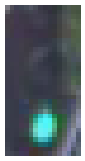

In [61]:
img_show(yellow_0)

In [62]:
np.unique(y_train), np.unique(sample['bbox'])

(array([0, 1, 2, 3]), array([0, 1, 2, 3]))

In [63]:
for i in range(4):
    print(i, y_train[y_train==i].shape)

0 torch.Size([351])
1 torch.Size([35])
2 torch.Size([490])
3 torch.Size([324])


In [64]:
for i in range(4):
    print(i, y_test[y_test==i].shape)

0 torch.Size([149])
1 torch.Size([23])
2 torch.Size([210])
3 torch.Size([124])


In [65]:

epochs = 120
device = torch.device('cuda:0')

batch_size = 64
num_classes = 4
lr = 1e-4

import torchvision
model = Net()


optimizer = torch.optim.Adam(model.parameters(), lr=lr)
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
for epoch in range(epochs):
    train(model, X_train, y_train, optimizer)
    test_loss, cr = test(model, X_test, y_test)
    print("Epoch: {}, test loss: {}".format(epoch, test_loss))
    print(cr)

[0 1 3]
Epoch: 0, test loss: 6.65277557976161
              precision    recall  f1-score   support

           0       0.40      0.88      0.55       149
           1       0.29      0.43      0.35        23
           2       0.00      0.00      0.00       210
           3       0.26      0.29      0.27       124

    accuracy                           0.35       506
   macro avg       0.24      0.40      0.29       506
weighted avg       0.19      0.35      0.24       506

[0 1 2 3]
Epoch: 1, test loss: 3.711013733633893
              precision    recall  f1-score   support

           0       0.34      0.07      0.12       149
           1       0.25      0.91      0.39        23
           2       0.52      0.12      0.19       210
           3       0.28      0.76      0.40       124

    accuracy                           0.30       506
   macro avg       0.35      0.47      0.28       506
weighted avg       0.40      0.30      0.23       506



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0 1 2 3]
Epoch: 2, test loss: 3.490768492928607
              precision    recall  f1-score   support

           0       0.67      0.01      0.03       149
           1       0.10      0.13      0.12        23
           2       0.36      0.71      0.48       210
           3       0.15      0.07      0.10       124

    accuracy                           0.32       506
   macro avg       0.32      0.23      0.18       506
weighted avg       0.39      0.32      0.24       506

[1 2 3]
Epoch: 3, test loss: 4.276405304316946
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       149
           1       0.00      0.00      0.00        23
           2       0.41      0.98      0.58       210
           3       0.33      0.02      0.03       124

    accuracy                           0.41       506
   macro avg       0.19      0.25      0.15       506
weighted avg       0.25      0.41      0.25       506

[1 2 3]
Epoch: 4, test loss: 3.526

In [69]:
help(torch.save)

Help on function save in module torch.serialization:

save(obj, f: Union[str, os.PathLike, BinaryIO, IO[bytes]], pickle_module=<module 'pickle' from '/usr/lib/python3.7/pickle.py'>, pickle_protocol=2, _use_new_zipfile_serialization=True) -> None
    Saves an object to a disk file.
    
    See also: `saving-loading-tensors`
    
    Args:
        obj: saved object
        f: a file-like object (has to implement write and flush) or a string or
           os.PathLike object containing a file name
        pickle_module: module used for pickling metadata and objects
        pickle_protocol: can be specified to override the default protocol
    
    .. note::
        A common PyTorch convention is to save tensors using .pt file extension.
    
    .. note::
        PyTorch preserves storage sharing across serialization. See
        `preserve-storage-sharing` for more details.
    
    .. note::
        The 1.6 release of PyTorch switched ``torch.save`` to use a new
        zipfile-based fil

In [70]:
with open('signal_classifier.torch', 'wb') as f:
    torch.save(model, f)